In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle

In [2]:
# utility functions

def show_image(img, title=""):
    f, ax = plt.subplots(1, 1, figsize=(10,5))
    f.tight_layout()

    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img[:,:,::-1])
    ax.axis('off')
    ax.set_title(title, fontsize=15)
    
def show_image2(img1, img2, title1='', title2=''):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.tight_layout()
    
    if img1.ndim == 2:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1[:,:,::-1])
    
    if img2.ndim == 2:
        ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2[:,:,::-1])

    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title(title1, fontsize=15)
    ax2.set_title(title2, fontsize=15)

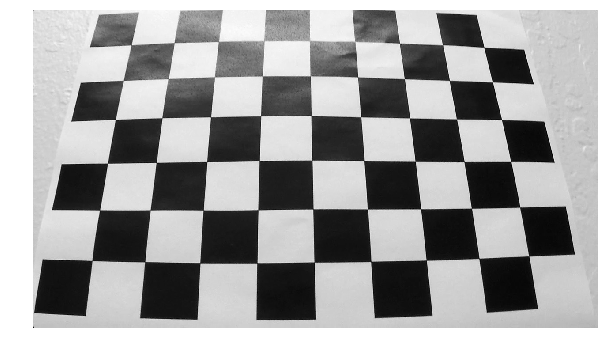

In [3]:
# read and draw one calibration image

fname = 'camera_cal/calibration3.jpg'
img = cv2.imread(fname)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(gray)
img_size = (gray.shape[1], gray.shape[0])

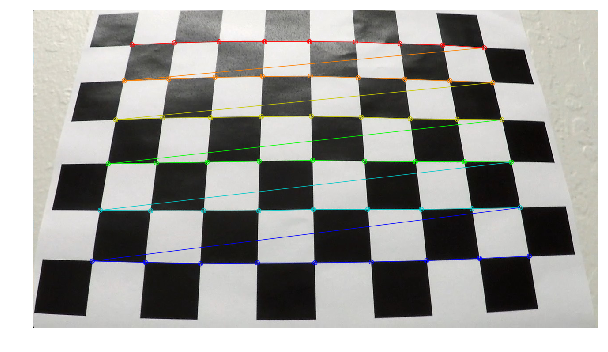

In [4]:
# finding the chessboard corners and draw them for verification

nx, ny = 9, 6
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret:
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    show_image(img)

In [5]:
# calc camera calibration coefficients from the files of 'camera_cal/cal*.jpg'

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

draw_images = False
count = 0

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        count += 1

        # Draw and display the corners
        if draw_images:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)
    else:
        print("failed and skipped", fname)

if draw_images:
    cv2.destroyAllWindows()

print("finished corner finding of count =", count)

failed and skipped camera_cal/calibration1.jpg
failed and skipped camera_cal/calibration4.jpg
failed and skipped camera_cal/calibration5.jpg
finished corner finding of count = 17


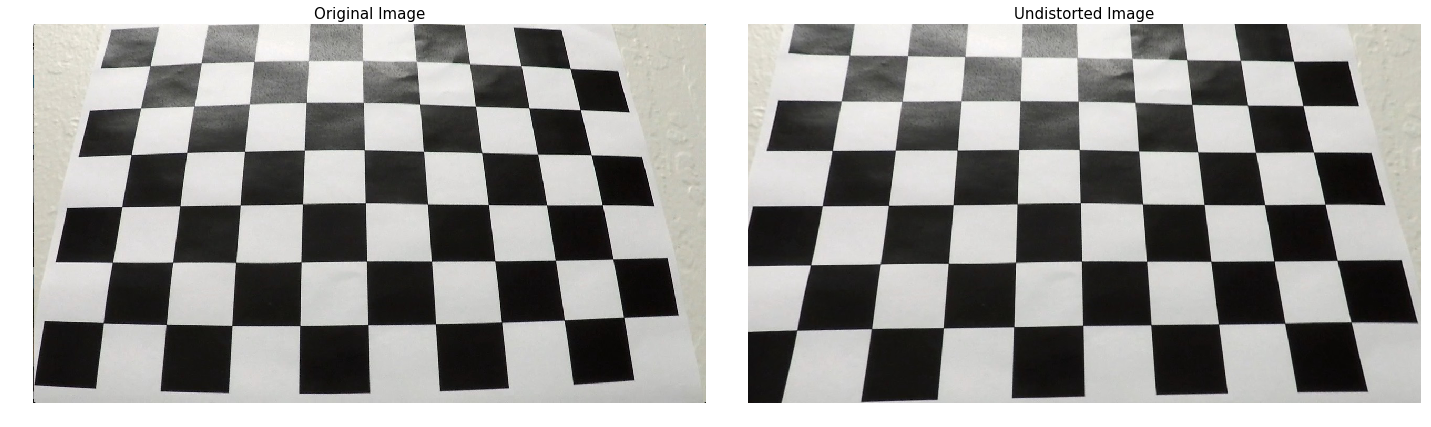

In [6]:
# undistorted the calibration3.jpg for verification
fname = 'camera_cal/calibration3.jpg'
img = cv2.imread(fname)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

cv2.imwrite("examples/undist_calibration3.jpg", undist)
show_image2(img, undist, 'Original Image', 'Undistorted Image')

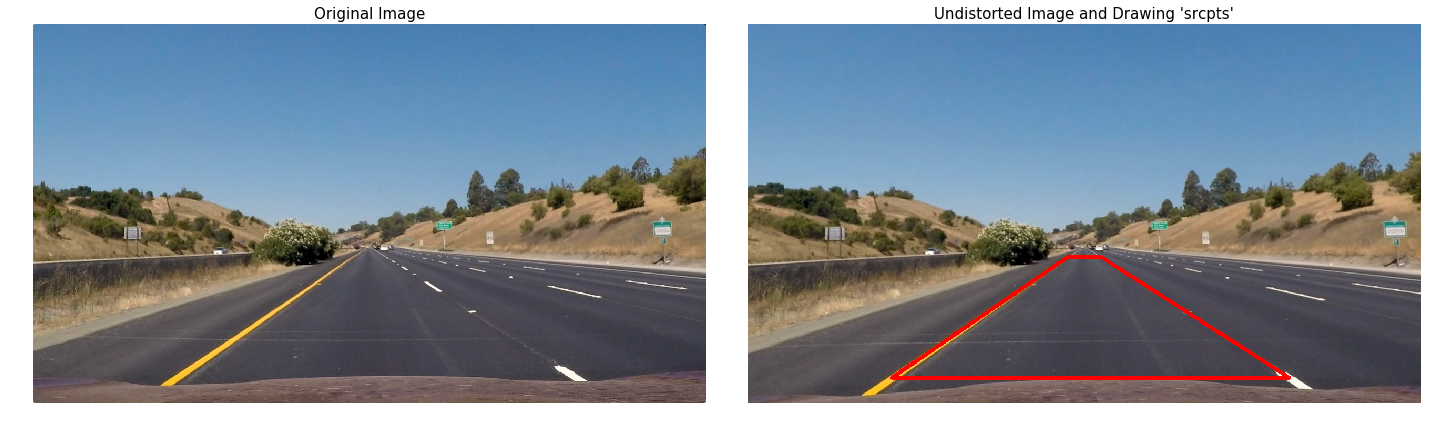

In [7]:
# read reference images, undistort it, and draw the srcpts
fname = 'test_images/straight_lines1.jpg'
img = cv2.imread(fname)

undist = cv2.undistort(img, mtx, dist, None, mtx)
srcpts = [(273, 672), (1030, 672), (671, 442), (608, 442)]
undist_with_pts = undist.copy()
pts = [np.array(srcpts)]
cv2.polylines(undist_with_pts, pts, True, (0,0,255), 5)

cv2.imwrite('examples/undist_straight_lines1.jpg', undist_with_pts)
show_image2(img, undist_with_pts, "Original Image", "Undistorted Image and Drawing 'srcpts'")

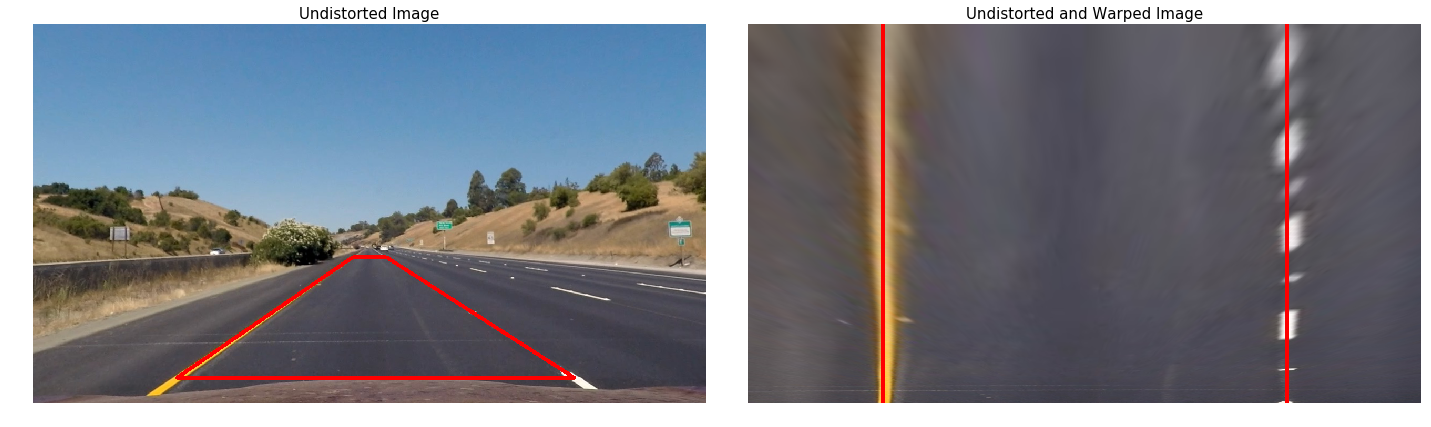

In [8]:
# calc perspective transform M and warped the image using warpPerspective

R = 0.2
iw, ih = img_size
srcpts = [(273, 672), (1030, 672), (671, 442), (608, 442)]
dstpts = [(iw*R,ih), (iw*(1-R),ih), (iw*(1-R),0), (iw*R,0)]
M = cv2.getPerspectiveTransform(np.float32(srcpts), np.float32(dstpts))
warped = cv2.warpPerspective(undist, M, img_size)

line2 = [(iw*R, 0), (iw*R, ih)]
line1 = [(iw*(1-R), 0), (iw*(1-R), ih)]
pts = [np.int32(line1), np.int32(line2)]
cv2.polylines(warped, pts, False, (0,0,255), 5)

cv2.imwrite('examples/warped_straight_lines1.jpg', warped)
show_image2(undist_with_pts, warped, 'Undistorted Image', 'Undistorted and Warped Image')

In [9]:
# save coeffecients and used in the '02-advance_lane_lines.ipynb'

fname = "camera_cal/dist_pickle.p"
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["M"] = M
dist_pickle["img_size"] = img_size
pickle.dump( dist_pickle, open( fname, "wb" ) )
print("'{}' is saved.".format(fname))

'camera_cal/dist_pickle.p' is saved.
